In [ ]:
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import loader as load
import processor as pr
from torch.utils.data import Dataset, DataLoader

In [ ]:

target="tumor"
c="STAD"
data, files_names = load.loadAll(includeStage=(target=="stage"), sameSamples=True, skipGenes=True)
ge_genus, ge_genus_name = data[-1], files_names[-1]
ge_genus = load.attachTumorStatus(ge_genus)

x, y = pr.splitData(ge_genus, target=target, project=c)
x = x.drop(x.iloc[:, 5:5216], axis=1)
x

In [44]:
# https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

class OverlapDataset(Dataset):
    """Genus + GE dataset."""

    def __init__(self, target, cancer):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data, files_names = load.loadAll(includeStage=(target=="stage"), sameSamples=True, skipGenes=True)
        ge_genus, ge_genus_name = data[-1], files_names[-1]

        if target=="tumor":
            ge_genus = load.attachTumorStatus(ge_genus)
        else:
            ge_genus = load.attachStageStatus(ge_genus)

        x, y = pr.splitData(ge_genus, target=target, project=cancer)
        x = x.drop(x.iloc[:, 5:5216], axis=1)
        
        self.modality_features = x
        self.targets = y


    def __len__(self):
        return len(self.modality_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_features = self.modality_features.iloc[idx].values
        sample_target = self.targets.iloc[idx]
        sample = {'features': sample_features, 'target': sample_target}

        return sample

In [52]:
overlapped = OverlapDataset("tumor", "STAD")
# Display text and label.
print('\nFirst iteration of data set: ', next(iter(overlapped)), '\n')
# Print how many items are in the data set
print('Length of data set: ', len(overlapped), '\n')
# Print entire data set
print('Entire data set: ', list(DataLoader(overlapped))[:2], '\n')

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = overlapped,
									batch_size = 16,
									shuffle = True)
									
print('Batched data set: ', list(loader)[:2], '\n')


First iteration of data set:  {'features': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.65618724, 0.77328287, 0.14825781, 0.18096101, 0.53191298]), 'target': 1} 

Length of data set:  122 

Entire data set:  [{'features': tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6562, 0.7733, 0.1483, 0.1810,
         0.5319]], dtype=torch.float64), 'target': tensor([1])}, {'features': tensor([[0.0000, 0.0000, 0.0000, 0.1066, 0.0000, 0.5604, 0.7994, 0.0535, 0.1874,
         0.5761]], dtype=torch.float64), 'target': tensor([1])}] 

Batched data set:  [{'features': tensor([[0.0000, 0.0342, 0.0000, 0.0000, 0.0000, 0.3917, 0.7918, 0.1471, 0.4293,
         0.4048],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4160, 0.8177, 0.1823, 0.1473,
         0.5643],
        [0.0000, 0.0000, 0.0000, 0.5073, 0.0000, 0.4880, 0.7504, 0.2665, 0.2184,
         0.5942],
        [0.0000, 0.0000, 0.0193, 0.0000, 0.0000, 0.6294, 0.7996, 0.0000, 0.1733,
         0.5525],
        [0

In [ ]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(10, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 9)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(9, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 10),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return encoded, decoded


In [ ]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)

hidden:  tensor([[-679.1512, -724.4585, -780.1794, -819.9312, -656.9279,  585.4766,
          607.4928, -672.4061,  661.5443],
        [-612.9869, -653.9212, -704.1911, -740.0513, -592.9258,  528.4536,
          548.3508, -606.8660,  597.1391],
        [-562.3045, -599.8680, -645.9692, -678.8735, -543.9310,  484.7793,
          503.0254, -556.6990,  547.7830],
        [-566.2536, -604.0820, -650.5070, -683.6392, -547.7457,  488.1814,
          506.5594, -560.6042,  551.6320],
        [-508.8409, -542.8489, -584.5526, -614.3379, -492.2468,  438.7079,
          455.2133, -503.7780,  495.7197],
        [-595.3109, -635.0828, -683.8931, -718.7081, -575.8202,  513.2178,
          532.5560, -589.3478,  579.9398],
        [-486.1796, -518.6840, -558.5223, -586.9820, -470.3353,  419.1788,
          434.9510, -481.3410,  473.6564],
        [-566.8183, -604.6817, -651.1546, -684.3221, -548.2949,  488.6691,
          507.0620, -561.1674,  552.1783],
        [-564.1995, -601.8922, -648.1482, -681.

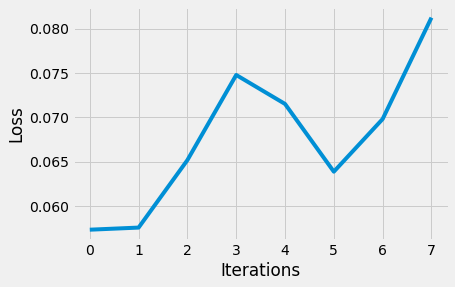

In [60]:
epochs = 1
outputs = []
losses = []
for epoch in range(epochs):
	for batch_id, batched_samples in enumerate(loader):
		features = batched_samples["features"].float()
		
		# Output of Autoencoder
		hidden, reconstructed = model(features)
		
		# Calculating the loss function
		loss = loss_function(reconstructed, features)
		print("hidden: ", hidden)
		
		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses.append(loss.detach())
		outputs.append((epochs, features, reconstructed))

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])